Companion notebook for the paper: AI-guided phage formulation delivered via injectable hydrogels for localized control of implant-associated infections.

## Libraries

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
! pip install biopython transformers datasets pathlib hdbscan

In [ ]:
from Bio import Entrez
import pandas as pd, json, time, joblib

## Data Prep

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fereshte/cleaned_with_acc.csv')
df.head()

### Read FASTA Files

In [ ]:
from pathlib import Path
from Bio import SeqIO

GENOMES_DIR = Path("/content/drive/MyDrive/fereshte/genomes")  # ← adjust if needed

wanted  = df["ncbi_acc"].dropna().unique()   # accessions we expect
seqs    = {}          # {acc : DNA string}
missing = []          # list of accs without a file

for acc in wanted:
    fpath = GENOMES_DIR / f"{acc}.fasta"
    if fpath.exists():
        seqs[acc] = str(next(SeqIO.parse(fpath, "fasta")).seq)
    else:
        missing.append(acc)

print(f"Loaded {len(seqs)} genomes, missing {len(missing)}")
print("First few lengths:", [len(s) for s in list(seqs.values())[:5]])

Loaded 331 genomes, missing 0
First few lengths: [94315, 131681, 14942, 41243, 97177]


### DNABert

In [ ]:
import torch, numpy as np
from transformers import AutoTokenizer, AutoModel

# load DNABERT‑6‑mer
tok = AutoTokenizer.from_pretrained("zhihan1996/DNA_bert_6",
                                    trust_remote_code=True)
bert = AutoModel.from_pretrained("zhihan1996/DNA_bert_6",
                                 trust_remote_code=True).eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
bert.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(4101, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)

In [ ]:
def embed_sequence(seq, k=6, window=510, stride=250):
    seq = seq.upper().replace("N", "")
    windows = [
        " ".join(seq[i+j : i+j+k] for j in range(window))
        for i in range(0, len(seq) - k - window + 1, stride)
    ]
    enc = tok(windows, return_tensors="pt", padding=True,
              truncation=True, max_length=512)
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        out = bert(**enc).last_hidden_state[:, 0, :]     # CLS (n_win × 768)
    return out.mean(0).cpu().numpy()                     # 768‑d vector

#### test

In [ ]:
import time
now = time.time()
# test on the first genome we loaded earlier
first_acc   = next(iter(seqs))
test_embed  = embed_sequence(seqs[first_acc])
print(first_acc, test_embed.shape)   # should print “… (768,)”
print(time.time()-now)

NC_073607.1 (768,)
2.357314348220825


In [ ]:
from tqdm.auto import tqdm          # progress bar
import joblib                       # fast pickle

embeddings = []
good_acc   = []
failed_acc = []

for acc, seq in tqdm(seqs.items(), desc="Embedding genomes"):
    try:
        vec = embed_sequence(seq)
        embeddings.append(vec)
        good_acc.append(acc)
    except Exception as e:
        print(f"⚠️  {acc}: {e}")
        failed_acc.append(acc)

print(f"Done: {len(good_acc)} embedded, {len(failed_acc)} failed")

# put embeddings into a dataframe
emb_df = pd.DataFrame(embeddings, index=good_acc)
emb_df.columns = [f"emb_{i}" for i in range(768)]   # nice column names
emb_df["ncbi_acc"] = emb_df.index                   # restore key

# merge onto the main metadata table
df_emb = df.merge(emb_df, on="ncbi_acc", how="left")

# save for reuse
joblib.dump(df_emb, "/content/drive/MyDrive/fereshte/phage_with_dnabert.pkl")
print("✅  Saved embeddings to phage_with_dnabert.pkl")


Embedding genomes:   0%|          | 0/331 [00:00<?, ?it/s]

⚠️  NC_048170.1: CUDA out of memory. Tried to allocate 5.55 GiB. GPU 0 has a total capacity of 39.56 GiB of which 674.88 MiB is free. Process 3725 has 38.89 GiB memory in use. Of the allocated memory 29.85 GiB is allocated by PyTorch, and 8.55 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
⚠️  NC_071039.1: CUDA out of memory. Tried to allocate 6.71 GiB. GPU 0 has a total capacity of 39.56 GiB of which 5.04 GiB is free. Process 3725 has 34.51 GiB memory in use. Of the allocated memory 22.61 GiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://py

KeyboardInterrupt: 

In [ ]:
df_emb = joblib.load("/content/drive/MyDrive/fereshte/phage_with_dnabert.pkl")
df_emb = df_emb.dropna(subset=['ncbi_acc'])

### Pharokka + Phold

### Installation

In [ ]:
%%bash

set -e

PYTHON_VERSION="3.10"
PHAROKKA_VERSION="1.7.5"
PHOLD_VERSION="0.2.0"

echo "python version ${PYTHON_VERSION}"

if [ ! -f CONDA_READY ]; then
  echo "installing python"
  wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
  bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
  rm Miniconda3-latest-Linux-x86_64.sh
  conda config --set auto_update_conda false
  touch CONDA_READY
fi

if [ ! -f PHAROKKA_PHOLD_READY ]; then
  echo "installing pharokka and phold"
  conda install -y -c conda-forge -c bioconda pip pharokka==${PHAROKKA_VERSION} python=${PYTHON_VERSION} phold==${PHOLD_VERSION} pytorch=*=cuda*
  touch PHAROKKA_PHOLD_READY
fi

Process is terminated.


In [ ]:
# Download pharokka phold databases
# It will take some time (5-10 minutes probably). Please be patient. :/

%%time
import os
print("Downloading pharokka database. This will take a few minutes. Please be patient :)")
os.system("install_databases.py -o pharokka_db")
print("Downloading phold database. This will take a few minutes. Please be patient :)")
os.system("phold install -d phold_db")

#### Run Them

In [ ]:
%%time
import os, sys, subprocess, glob, pandas as pd, zipfile, tqdm

# ─────────────────────────────────────────────────────────────
# CONFIG — tweak only if your paths or prefs differ
INPUT_DIR        = "/content/drive/MyDrive/fereshte/genomes"
OUTPUT_ROOT      = "/content/drive/MyDrive/fereshte/pharokka"
PHAROKKA_DB      = "pharokka_db"   # folder with the downloaded DB
PHOLD_DB         = "phold_db"      # folder with the downloaded DB
THREADS          = 4               # Colab Pro: leave 4 for safety
GENE_PREDICTOR   = "phanotate"     # 'phanotate', 'prodigal', 'prodigal-gv'
FAST_MODE        = True            # adds --fast to Pharokka
FORCE_REWRITE    = True            # overwrite existing outputs
ZIP_EACH_SAMPLE  = False           # set True if you want zipped folders
# ─────────────────────────────────────────────────────────────

allowed_predictors = {'phanotate', 'prodigal', 'prodigal-gv'}
if GENE_PREDICTOR not in allowed_predictors:
    raise ValueError(f"GENE_PREDICTOR must be one of {allowed_predictors}")

fasta_paths = sorted(glob.glob(os.path.join(INPUT_DIR, "*.f*")))
if not fasta_paths:
    sys.exit(f"No FASTA files found in {INPUT_DIR}")

manifest_rows = []

for fasta in tqdm.tqdm(fasta_paths, desc="Annotating"):
    sample = os.path.splitext(os.path.basename(fasta))[0]   # “AB823818.1”
    out_dir = os.path.join(OUTPUT_ROOT, sample)
    os.makedirs(out_dir, exist_ok=True)

    # ——— Pharokka
    pharokka_prefix = sample            # keeps filenames unique
    cmd_pharokka = (
        f"pharokka.py -d {PHAROKKA_DB}"
        f" -i {fasta}"
        f" -t {THREADS}"
        f" -o {out_dir}"
        f" -p {pharokka_prefix}"
        f" -l {sample}"                 # locus tag = sample
        f" -g {GENE_PREDICTOR}"
    )
    if FAST_MODE:   cmd_pharokka += " --fast"
    if FORCE_REWRITE: cmd_pharokka += " -f"

    subprocess.run(cmd_pharokka, shell=True, check=True)

    # path to the GenBank file Pharokka just wrote
    gbk_file = os.path.join(out_dir, f"{pharokka_prefix}.gbk")
    if not os.path.exists(gbk_file):
        raise FileNotFoundError(f"Expected {gbk_file} not found")

    # ——— PHold
    phold_out = os.path.join(out_dir, "phold")
    os.makedirs(phold_out, exist_ok=True)
    cmd_phold = (
        f"phold run -i {gbk_file}"
        f" -t {THREADS}"
        f" -o {phold_out}"
        f" -p phold"
        f" -d {PHOLD_DB}"
    )
    if FORCE_REWRITE: cmd_phold += " -f"
    subprocess.run(cmd_phold, shell=True, check=True)

    # ——— optional zip
    if ZIP_EACH_SAMPLE:
        zip_path = f"{out_dir}.zip"
        with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
            for root, _, files in os.walk(out_dir):
                for file in files:
                    fp = os.path.join(root, file)
                    zipf.write(fp, os.path.relpath(fp, out_dir))

    # ——— record for manifest
    manifest_rows.append({
        "sample":            sample,
        "fasta":             fasta,
        "pharokka_gff":      os.path.join(out_dir, f"{pharokka_prefix}.gff"),
        "pharokka_funcs":    os.path.join(out_dir, f"{pharokka_prefix}_cds_functions.tsv"),
        "phold_per_cds":     os.path.join(phold_out, "phold_per_cds_predictions.tsv"),
        "phold_all_cds":     os.path.join(phold_out, "phold_all_cds_functions.tsv"),
    })

# ——— save manifest
manifest = pd.DataFrame(manifest_rows)
manifest_path = os.path.join(OUTPUT_ROOT, "analysis_manifest.csv")
manifest.to_csv(manifest_path, index=False)
print(f"\n✓ All done. Manifest saved → {manifest_path}  ({len(manifest)} genomes)")

Annotating:   0%|          | 0/331 [00:00<?, ?it/s]


CalledProcessError: Command 'pharokka.py -d pharokka_db -i /content/drive/MyDrive/fereshte/genomes/AB823818.1.fasta -t 4 -o /content/drive/MyDrive/fereshte/pharokka/AB823818.1 -p AB823818.1 -l AB823818.1 -g phanotate --fast -f' returned non-zero exit status 127.

### Load the manifest

In [ ]:
%%time
import pandas as pd, os, glob

HOST_FILTER   = "Pseudomonas aeruginosa"
MANIFEST      = "/content/drive/MyDrive/fereshte/pharokka/analysis_manifest.csv"
PHAROKKA_ROOT = "/content/drive/MyDrive/fereshte/pharokka"

emb_pa = df_emb[df_emb["host_full"] == HOST_FILTER].copy()
print(f"Phages with host {HOST_FILTER}: {len(emb_pa)}")

meta = pd.read_csv(MANIFEST)
meta_pa = meta[meta["sample"].isin(emb_pa["ncbi_acc"])]
print(f"Matching Pharokka annotations found: {len(meta_pa)}")

# parse
def parse_one(row):
    sample = row["sample"]
    outdir = os.path.join(PHAROKKA_ROOT, sample)

    # cds_functions.tsv  (Description ↦ Count)
    func_tsv = row["pharokka_funcs"]
    f_df = pd.read_csv(func_tsv, sep="\t")
    func_dict = f_df.set_index("Description")["Count"].to_dict()

    # length / GC / coding density
    len_tsv = glob.glob(os.path.join(outdir, "*_length_gc_cds_density.tsv"))[0]
    l_df = pd.read_csv(len_tsv, sep="\t")
    len_dict = l_df.iloc[0][["length", "gc_perc", "cds_coding_density"]].to_dict()

    return {
        "ncbi_acc": sample,
        **{f"FUNC_{k}": v for k, v in func_dict.items()},
        **len_dict,
    }

feat_rows = [parse_one(r) for _, r in meta_pa.iterrows()]
feat_df = (
    pd.DataFrame(feat_rows)
      .fillna(0)
      .set_index("ncbi_acc")
)

# merge
full_df = (
    emb_pa.set_index("ncbi_acc")
          .join(feat_df, how="inner")
          .reset_index()
)

print("Merged dataframe shape:", full_df.shape)
display(full_df.head())


In [ ]:
full_df.to_csv("/content/drive/MyDrive/fereshte/PA_phage_with_dnabert_and_pharokka.csv", index=False)

## Clustering

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


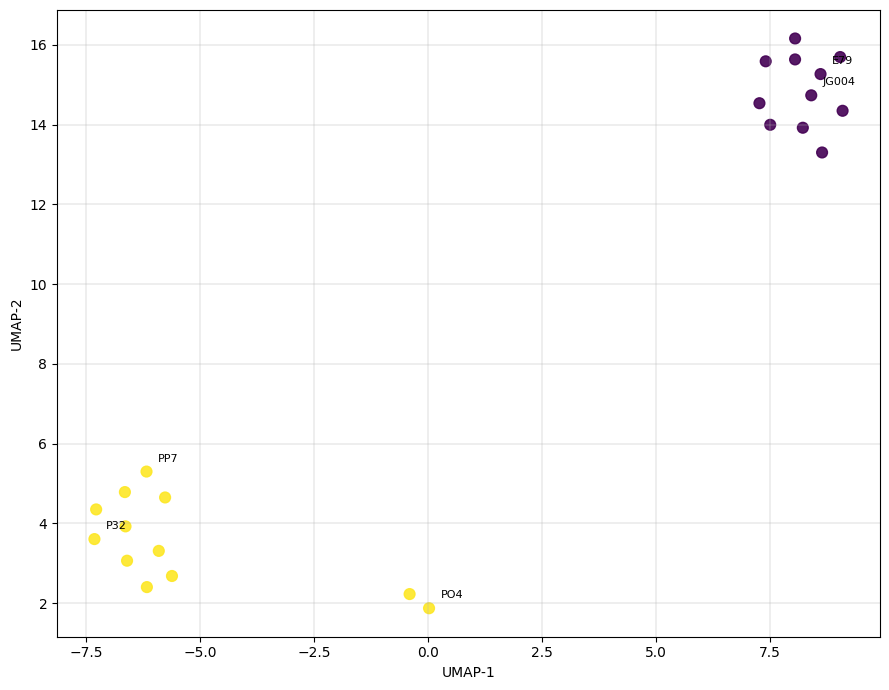

CPU times: user 200 ms, sys: 2.93 ms, total: 203 ms
Wall time: 2.49 s


In [ ]:
%%time
# one‑time install (skip if umap‑learn is already present)
!pip -q install umap-learn

import numpy as np, pandas as pd, matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

# feature matrix
embed_cols = [c for c in full_df.columns if c.startswith("embed_")]
func_cols  = [c for c in full_df.columns
              if c.startswith("FUNC_") or c in ['length','gc_perc','cds_coding_density']]


X = full_df[embed_cols + func_cols].astype(float).to_numpy()
X = StandardScaler().fit_transform(X)

umap = umap.UMAP(
    n_neighbors=10,
    min_dist=0.4,           # smaller = tighter blobs
    random_state=0
)
xy = umap.fit_transform(X)

# plot
y = np.arange(len(full_df)) % 2  # dummy colors for visualization
plt.figure(figsize=(9,7))
plt.scatter(xy[:,0], xy[:,1], c=y, s=60, alpha=0.9)

for i, name in enumerate(full_df['phage']):
    if name in ["E79", "JG004", "PO4", "PP7", "P32"]:
      plt.text(xy[i,0] + 0.25, xy[i,1] + 0.25, name, fontsize=8)

# plt.title("", pad=15)
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
plt.grid(lw=0.3); plt.tight_layout(); plt.show()
